# Linear Regression Practice

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np

from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, LogisticRegression, LassoLarsCV, Ridge

1. Reading Data

In [2]:
data = pd.read_csv('train.csv', index_col=0)
data.shape

(1460, 80)

In [3]:
data.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,
1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


2. Visualizing Data

In [4]:
%matplotlib inline

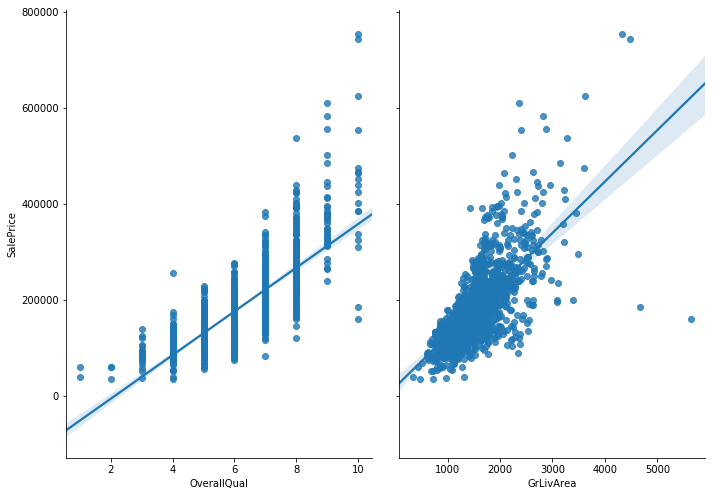

In [6]:
sns.pairplot(data, x_vars=['OverallQual', 'GrLivArea'], y_vars='SalePrice', height=7, aspect=0.7, kind='reg')

3. Checking correlation

In [7]:
traincorr = data.corr()['SalePrice']
traincorr = pd.DataFrame(traincorr)
traincorr.columns = ["Corr"]
traincorr_ordered = traincorr.sort_values(by=['Corr'],ascending=False)
traincorr_ordered.head(20)

,Corr
SalePrice,1.000000
OverallQual,0.790982
GrLivArea,0.708624
GarageCars,0.640409
GarageArea,0.623431
TotalBsmtSF,0.613581
1stFlrSF,0.605852
FullBath,0.560664
TotRmsAbvGrd,0.533723
YearBuilt,0.522897


4. Checking mising data

In [8]:
countmissing = data.isnull().sum().sort_values(ascending=False)
percentmissing = (data.isnull().sum()/data.isnull().count()).sort_values(ascending=False)
data_miss = pd.concat([countmissing,percentmissing], axis=1)
data_miss.columns = ["count","%"]
count = data_miss['count'] > 0
data_miss[count]

,count,%
PoolQC,1453,0.995205
MiscFeature,1406,0.963014
Alley,1369,0.937671
Fence,1179,0.807534
FireplaceQu,690,0.472603
LotFrontage,259,0.177397
GarageType,81,0.055479
GarageQual,81,0.055479
GarageCond,81,0.055479
GarageFinish,81,0.055479


4. Filling missing data

In [9]:
data['Electrical'] = data.Electrical.fillna("SBrkr")
data['MasVnrType'] = data.MasVnrType.fillna("None")

In [10]:
data['MasVnrArea']= data.MasVnrArea.fillna(data.MasVnrArea.mean())

In [11]:
data.GarageYrBlt.fillna(data.YearBuilt, inplace=True)

In [12]:
data['LotFrontage']= data.LotFrontage.fillna(data.LotArea)
data['LotFrontage']= data['LotFrontage'].astype(int)

5. Creating new features based on more correlated ones

In [13]:
# Total Living Area
Livingtotalsf = data['TotalBsmtSF'] + data['1stFlrSF'] + data['2ndFlrSF'] + data['GarageArea'] + data['WoodDeckSF'] + data['OpenPorchSF']
data['LivingTotalAreaSF'] = Livingtotalsf

# Total Living Area percentage
data['PercentSQtoLot'] = data['LivingTotalAreaSF'] / data['LotArea']

# Total amount of bathrooms withing the building, including full and half
data['TotalBaths'] = data['BsmtFullBath'] + data['BsmtHalfBath'] + data['HalfBath'] + data['FullBath']

# Percentage of total rooms are bedrooms
data['PercentBedrmtoRooms'] = data['BedroomAbvGr'] / data['TotRmsAbvGrd']

# Time since last remodel in years
data['YearsSinceRemodel'] = 2018 - ((data['YearRemodAdd'] - data['YearBuilt']) + data['YearBuilt'])

In [14]:
traincorr = data.corr()['SalePrice']
traincorr = pd.DataFrame(traincorr)
traincorr.columns = ["Corr"]
traincorr_ordered = traincorr.sort_values(by=['Corr'],ascending=False)
traincorr_ordered.head(30)

,Corr
SalePrice,1.000000
LivingTotalAreaSF,0.815688
OverallQual,0.790982
GrLivArea,0.708624
GarageCars,0.640409
GarageArea,0.623431
TotalBsmtSF,0.613581
TotalBaths,0.613005
1stFlrSF,0.605852
FullBath,0.560664


6. Selecting final features

In [15]:
price = data['SalePrice']

neigh = data[['Neighborhood','MSZoning','MSSubClass','BldgType','HouseStyle']]

dates = data[['YearBuilt','YearRemodAdd','GarageYrBlt','YearsSinceRemodel']]

quacon = data[['ExterQual','BsmtQual','PoolQC','Condition1','Condition2','SaleCondition',
                  'BsmtCond','ExterCond','GarageCond','KitchenQual','GarageQual','HeatingQC','OverallQual','OverallCond']]

features =  data[['Foundation','RoofStyle','RoofMatl','Exterior1st','Exterior2nd',
                     'MiscFeature','PavedDrive','Utilities',
                     'Heating','CentralAir','Electrical','Fence']]

sqfoot = data[['LivingTotalAreaSF','TotalBsmtSF','1stFlrSF','2ndFlrSF','GrLivArea',
                  'GarageArea','WoodDeckSF','OpenPorchSF','LotArea','PercentSQtoLot','LowQualFinSF']]

roomfeatcount = data[['PercentBedrmtoRooms','TotalBaths','FullBath','HalfBath',
                         'KitchenAbvGr','TotRmsAbvGrd','Fireplaces','GarageCars','EnclosedPorch']]


In [16]:
X = pd.concat([neigh,dates,quacon,features,sqfoot,roomfeatcount], axis=1)

In [17]:
X.shape

(1460, 55)

In [18]:
data = pd.get_dummies(data)

In [19]:
data.shape

(1460, 294)

7. Setting final data (train/test)

In [20]:
X = data
X.shape

(1460, 294)

In [21]:
y = price[price.notnull()]
y.shape

(1460,)

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

In [23]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(1095, 294)
(365, 294)
(1095,)
(365,)


8. Linear Regression

In [24]:
from sklearn.linear_model import LinearRegression, LogisticRegression, LassoLarsCV, Ridge

linreg = LinearRegression()

linreg.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [25]:
# print the intercept and coefficients
print(linreg.intercept_)
print(linreg.coef_)

3.754394128918648e-09
[ 1.32768924e-14  5.21804822e-15 -3.49720253e-15 -2.79660013e-11
  2.64411279e-11  7.55159824e-14 -3.56924559e-13 -1.21936315e-13
 -8.05719423e-15  9.78567271e-14 -1.14120952e-14  7.86423877e-14
 -7.78523296e-14 -2.92129602e-14  1.73245993e-13  6.48639298e-14
  1.14029210e-11 -3.97184499e-12  1.79619019e-12 -1.70321024e-11
  3.15539801e-12 -1.01127643e-10  8.67039798e-12  3.04089476e-12
  5.10684482e-14  7.58951892e-12  4.79987619e-14 -4.92578966e-15
 -4.26448669e-14 -1.11836423e-13 -6.90402774e-14 -7.52399377e-14
 -2.10195265e-13  4.78727521e-15 -7.59840525e-13 -1.60203431e-12
  1.00000000e+00 -3.05274327e-14 -2.13794026e-11 -7.80489220e-12
 -9.80740475e-11  3.57126050e-13  8.99184346e-12  6.75636985e-12
 -1.30883120e-11 -4.25883800e-12  1.59893831e-12 -9.63747397e-13
  9.63747394e-13  5.89507557e-13 -7.33827033e-12  4.92155086e-12
  9.72218038e-12 -1.77604541e-11  3.11672286e-12 -4.32972458e-12
  6.06327830e-12 -4.97522913e-12  3.24167526e-12  1.22845933e-11
 -1

8. Predicting

In [26]:
y_pred = linreg.predict(X_test)

9. Cheking RMSE

In [27]:
y_test.shape, y_pred.shape

((365,), (365,))

In [29]:
print("RMSE: ")
print(np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

RMSE: 
7.941151868769361e-11


10. Predicting for test data (to check)

In [30]:
test_input = pd.read_csv('test.csv')
test_input.shape

(1459, 80)

In [31]:
test_input.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,...,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


In [32]:
countmissing = test_input.isnull().sum().sort_values(ascending=False)
percentmissing = (test_input.isnull().sum()/test_input.isnull().count()).sort_values(ascending=False)
data_miss = pd.concat([countmissing,percentmissing], axis=1)
data_miss.columns = ["count","%"]
count = data_miss['count'] > 0
data_miss[count]

,count,%
PoolQC,1456,0.997944
MiscFeature,1408,0.965045
Alley,1352,0.926662
Fence,1169,0.801234
FireplaceQu,730,0.500343
LotFrontage,227,0.155586
GarageCond,78,0.053461
GarageQual,78,0.053461
GarageYrBlt,78,0.053461
GarageFinish,78,0.053461


In [33]:
test_input['MasVnrArea']= test_input.MasVnrArea.fillna(test_input.MasVnrArea.mean())
test_input.GarageYrBlt.fillna(test_input.YearBuilt, inplace=True)
test_input['LotFrontage']= test_input.LotFrontage.fillna(test_input.LotArea)
test_input['LotFrontage']= test_input['LotFrontage'].astype(int)

In [34]:
# Total Living Area
Livingtotalsf = data['TotalBsmtSF'] + data['1stFlrSF'] + data['2ndFlrSF'] + data['GarageArea'] + data['WoodDeckSF'] + data['OpenPorchSF']
data['LivingTotalAreaSF'] = Livingtotalsf

# Total Living Area percentage
data['PercentSQtoLot'] = data['LivingTotalAreaSF'] / data['LotArea']

# Total amount of bathrooms withing the building, including full and half
data['TotalBaths'] = data['BsmtFullBath'] + data['BsmtHalfBath'] + data['HalfBath'] + data['FullBath']

# Percentage of total rooms are bedrooms
data['PercentBedrmtoRooms'] = data['BedroomAbvGr'] / data['TotRmsAbvGrd']

# Time since last remodel in years
data['YearsSinceRemodel'] = 2018 - ((data['YearRemodAdd'] - data['YearBuilt']) + data['YearBuilt'])

In [35]:
test_input = pd.get_dummies(test_input)
test_input.shape

(1459, 271)

In [ ]:
id = test_input['Id']
test_result = linreg.predict(test_input)

output = pd.DataFrame( { 'id': id , 'SalePrice': test_result} )
output = output[['id', 'SalePrice']]

output.to_csv("test_result.csv", index = False)

10. Referencces

https://towardsdatascience.com/introduction-to-machine-learning-algorithms-linear-regression-14c4e325882a
https://towardsdatascience.com/house-prices-and-regressions-7adf696053d6